In [1]:
import argparse
import easydict

from helper import load_model, load_images_deps, load_dl, \
                    load_optimizer_and_scheduler, load_devices, save_ckpt, \
                    pick_n_elements, trainer, evaluator, save_metrics_to_file, load_summary_writer




In [2]:
args_kt = easydict.EasyDict({
    "simple": False,
    "bins": 128,
    'epochs' : 10,
    'bs' : 1,
    'all-images' : False, 
    'NB_IMGS' : 200, 
    'dataset' : "kitti", 
    'train_txt' : './Data/splits/kitti/kitti_eigen_train_files_with_gt.txt',
    'test_txt' :'./Data/splits/kitti/kitti_eigen_test_files_with_gt.txt', 
    'images_path' : '/media/rcam/DEB075B7B07596AD/See/data/data/',
    'depths_path' : '/media/rcam/DEB075B7B07596AD/See/data/data_depth_annotated/',
    'max_depth' : 80., 'min_depth' : 1e-3,
    'image_height' : 352, 'image_width' : 704, 
    'ckpt' : './checkpoints/', 'txts' : './txts/',
    'scale_silog' : 3. , 'scale_joint' : 1., 'scale_hist' : 0.1,
    'optimizer' : 'AdamW', 'lr' : 0.0001, 'wd' : 0.1,
    'same-lr' : False, 'gpu-tr' : True, 'gpu-ts' : False, 'crop' : 'eigen'
})

In [3]:
model = load_model(args_kt)
imgs_ts, deps_ts = load_images_deps(args_kt, train=False)
valid_dl = load_dl(args_kt, imgs=imgs_ts[:], depths=deps_ts[:], train=False)




Loading base model tf_efficientnet_b5_ap Done.
Building Encoder-Decoder model..
It Will be a Combined Arm ... with 128 Bins
The total Number of trainable parameters will be : 76069809


In [4]:

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
from torchvision import transforms

# Define the original normalization transformation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define the inverse normalization transformation
class InverseNormalize(transforms.Normalize):
    def __init__(self, mean, std):
        mean = torch.tensor(mean)
        std = torch.tensor(std)
        # The inverse of the normalization is: (input * std) + mean
        inv_std = 1 / std
        inv_mean = -mean / std
        super().__init__(inv_mean.tolist(), inv_std.tolist())

inverse_normalize = InverseNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def plot_images(input_image, depth, output_image):
    """
    Plots the input and output images.
    
    Parameters:
    input_image (torch tensor): Input image of shape (1, 3, H, W)
    output_image (torch tensor): Output image of shape (1, 1, H, W)
    """
    # Convert torch tensors to numpy arrays
    input_image_np  = input_image.squeeze(0).permute(1, 2, 0).detach().numpy()
    output_image_np = output_image.squeeze(0).squeeze(0).detach().cpu().numpy()
    depth           = depth.squeeze(0)
    # Plot the input image
    plt.figure(figsize=(12, 10))
    
    plt.subplot(3, 1, 1)
    plt.imshow(input_image_np.astype(np.uint8))
    plt.title("Input Image")
    plt.axis('off')
    
    # Plot the output image
    plt.subplot(3, 1, 2)
    plt.imshow(output_image_np, cmap='magma_r')
    plt.title("Output Image")
    plt.axis('off')

    plt.subplot(3, 1, 3)
    plt.imshow(depth, cmap='magma_r')
    plt.title("depth Image")
    plt.axis('off')
    
    plt.show()

In [6]:
model.load_state_dict(torch.load("/media/rcam/481AF2891AF273742/data/checkpoints/Model_KITTI_LR_1e4_global_linear_Leaky_att_15_simple_128_with_pos/Model_KITTI_LR_1e4_global_linear_Leaky_att_15_simple_128_with_pos_abs_rel-0.07092_A1-0.94365_best.pt", map_location = torch.device('cpu')))
dataset = valid_dl.dataset

14


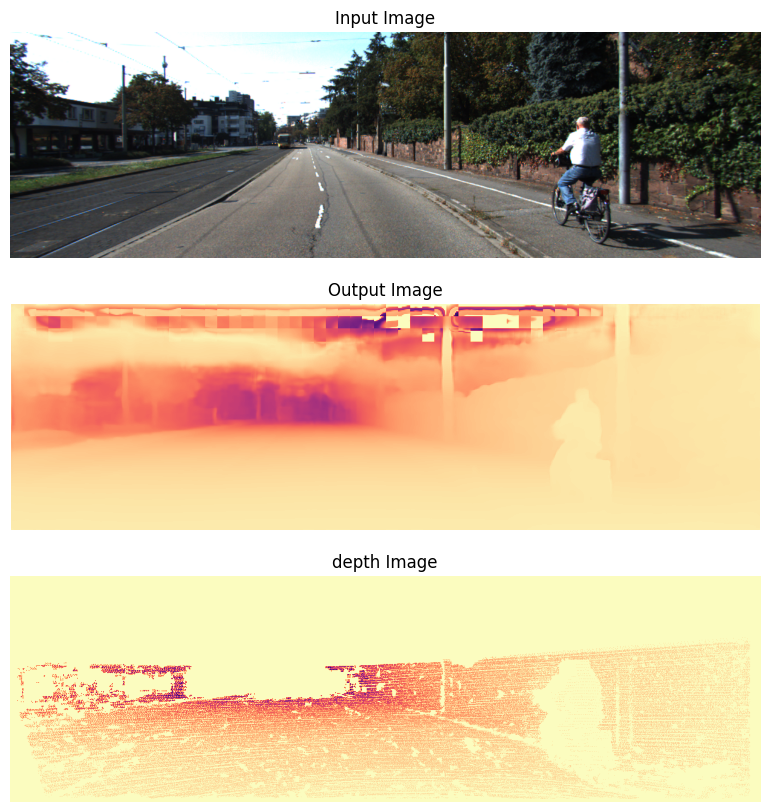

In [31]:
# Get a random sample 27 38 88 172 184 206 243 254 268 293 318 357 392 397 574 599 605 622 628 646 586 
random_index =  int(np.random.random()*len(dataset))
single_example = dataset[random_index]
img, depth = torch.tensor(np.expand_dims(single_example['image'], 0)) ,  np.expand_dims(single_example['depth'], 0) # single_example['depth']  # 
pred = model(img)
print(random_index)
plot_images((img)*255, depth, pred)
# 14, 33, 44, 59, 61, 74, 76, 105, 107, 110, 119,
# 154, 168, 172, 180, 181, 182, 206, 235, 251, 252,
# 257, 267, 273, 275, 284, 288, 289, 290, 293, 295, 
# 297, 302, 312, 335, 354, 363, 381, 389, 406, 417, 
# 425, 429, 435, 450, 458, 461, 470, 473, 475, 477, 
# 518, 520, 525, 531, 538, 542, 584, 596, 603, 612, 
# 614, 618, 627, 629, 631, 634, 635, 636, 640, 643, 
# 648, 649





